In [13]:
import sys
sys.path.append("./attention-module/MODELS")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Pulled offical module into my aws sagemaker ai lab space - then later wrote myself from paper.
from cbam import CBAM
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.models.resnet import BasicBlock

In [15]:
# BasicBlock taken from Resnet Paper https://arxiv.org/pdf/1512.03385 (pytorch module)

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)            
        self.block_64 = self.make_big_block(64, count=2)
        self.block_128 = self.make_big_block(128, count=2)
        self.block_256 = self.make_non_trans_big_block(256, count=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 200)
        self.dropout = nn.Dropout(0.5)

    def make_big_block(self, channel_count, count = 3, kernel_size = 3):
        ordering = []
        downsample = nn.Sequential(
            nn.Conv2d(channel_count, channel_count*2, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(channel_count*2),
        )
        for i in range(count):
            if i != count - 1:
                ordering.append(BasicBlock(channel_count, channel_count))
                ordering.append(CBAM(channel_count))
            else:
                ordering.append(BasicBlock(channel_count, channel_count*2, stride=2, downsample=downsample))
                ordering.append(CBAM(channel_count*2))

        return nn.Sequential(*ordering)

    def make_non_trans_big_block(self, channel_count, count = 3, kernel_size = 3):
        ordering = []

        for i in range(count):
            ordering.append(BasicBlock(channel_count, channel_count))

        return nn.Sequential(*ordering)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.block_64(x)
        x = self.block_128(x)
        x = self.block_256(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


size of validation dataset 300


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 0 Training Loss 5.345040955960562. Validation Loss 5.3111062939961755 Accuracy 0.3333333333333333


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 Training Loss 5.232089395057455. Validation Loss 5.198575038909912 Accuracy 0.6666666666666666


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 Training Loss 5.088350207922037. Validation Loss 5.5162824122111 Accuracy 1.6666666666666667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 Training Loss 4.952728018913095. Validation Loss 4.976344636281332 Accuracy 0.3333333333333333


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 Training Loss 4.84187480044189. Validation Loss 4.947179832458496 Accuracy 1.6666666666666667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5 Training Loss 4.737375754827695. Validation Loss 6.343255793253581 Accuracy 2.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6 Training Loss 4.6533166095169545. Validation Loss 4.6424652862548825 Accuracy 2.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7 Training Loss 4.533403149059793. Validation Loss 4.62783561706543 Accuracy 2.3333333333333335


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8 Training Loss 4.4363005003009635. Validation Loss 4.643125076293945 Accuracy 3.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9 Training Loss 4.333941109774194. Validation Loss 4.914306100209554 Accuracy 3.3333333333333335


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10 Training Loss 4.256417794356565. Validation Loss 4.276833012898763 Accuracy 7.666666666666667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11 Training Loss 4.139246665263201. Validation Loss 4.118049399058024 Accuracy 5.666666666666667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12 Training Loss 4.03386253283909. Validation Loss 4.382540658315023 Accuracy 7.333333333333333


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13 Training Loss 3.964860069822922. Validation Loss 4.196042372385661 Accuracy 8.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14 Training Loss 3.859205445449395. Validation Loss 4.236528638203938 Accuracy 9.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15 Training Loss 3.78183986992429. Validation Loss 3.9034127108256023 Accuracy 10.333333333333334


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16 Training Loss 3.72059921972116. Validation Loss 4.189687690734863 Accuracy 9.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17 Training Loss 3.613615601951296. Validation Loss 3.741420625050863 Accuracy 10.333333333333334


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18 Training Loss 3.5116732185834074. Validation Loss 3.7254250335693357 Accuracy 14.666666666666666


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19 Training Loss 3.436923922427211. Validation Loss 3.7460688654581706 Accuracy 12.333333333333334


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20 Training Loss 3.3636295171549415. Validation Loss 3.700132102966309 Accuracy 14.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 21 Training Loss 3.3050139272761503. Validation Loss 3.640556971232096 Accuracy 14.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 22 Training Loss 3.2354397369260153. Validation Loss 3.6418366686503094 Accuracy 17.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 23 Training Loss 3.1416331628016265. Validation Loss 4.02410665512085 Accuracy 15.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 24 Training Loss 3.0712289539688213. Validation Loss 3.5879347801208494 Accuracy 16.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 25 Training Loss 3.006528644340684. Validation Loss 3.764592768351237 Accuracy 18.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 26 Training Loss 2.9693749408199364. Validation Loss 3.7727601369222006 Accuracy 14.666666666666666


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 27 Training Loss 2.8972614859127774. Validation Loss 3.5275219535827635 Accuracy 19.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 28 Training Loss 2.8101554044221717. Validation Loss 3.7985313161214194 Accuracy 15.666666666666666


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 29 Training Loss 2.768228819213669. Validation Loss 3.440755481719971 Accuracy 22.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 30 Training Loss 2.7425752372795293. Validation Loss 3.391809622446696 Accuracy 21.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 31 Training Loss 2.6513797603743847. Validation Loss 3.3999162419637043 Accuracy 22.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 32 Training Loss 2.5869709023434444. Validation Loss 3.4002513758341473 Accuracy 22.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 33 Training Loss 2.5505294169213926. Validation Loss 3.5245392163594564 Accuracy 21.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 34 Training Loss 2.4901010166103896. Validation Loss 3.4972112147013346 Accuracy 19.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 35 Training Loss 2.445251691956917. Validation Loss 3.2073826217651367 Accuracy 26.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 36 Training Loss 2.362769494024879. Validation Loss 3.3274268595377605 Accuracy 26.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 37 Training Loss 2.3603956692671835. Validation Loss 3.520713103612264 Accuracy 19.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 38 Training Loss 2.2971824708636452. Validation Loss 3.0674663639068602 Accuracy 26.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 39 Training Loss 2.248761433570227. Validation Loss 3.2075653998057048 Accuracy 28.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 40 Training Loss 2.179332054159622. Validation Loss 3.0781217511494954 Accuracy 26.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 41 Training Loss 2.1725123778618887. Validation Loss 3.401283461252848 Accuracy 24.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 42 Training Loss 2.1255745455638375. Validation Loss 3.4898875935872398 Accuracy 27.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 43 Training Loss 2.06668462751621. Validation Loss 3.0272999223073325 Accuracy 29.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 44 Training Loss 1.9849103923676346. Validation Loss 2.980880994796753 Accuracy 29.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 45 Training Loss 1.9970128270756542. Validation Loss 3.543156248728434 Accuracy 25.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 46 Training Loss 1.9528680198603778. Validation Loss 3.2744310983022054 Accuracy 29.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 47 Training Loss 1.9364181745667854. Validation Loss 3.400468502044678 Accuracy 23.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 48 Training Loss 1.9178303684064453. Validation Loss 3.2320779927571617 Accuracy 28.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 49 Training Loss 1.8562668311960202. Validation Loss 3.2356228256225585 Accuracy 25.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 50 Training Loss 1.7576988388204893. Validation Loss 2.989341980616252 Accuracy 33.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 51 Training Loss 1.7427723495676344. Validation Loss 3.097748514811198 Accuracy 30.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 52 Training Loss 1.7168503202050454. Validation Loss 3.28562663714091 Accuracy 27.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 53 Training Loss 1.684241694402477. Validation Loss 3.2868400637308754 Accuracy 32.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 54 Training Loss 1.6232641589486645. Validation Loss 3.2315543778737386 Accuracy 30.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 55 Training Loss 1.6141447379457603. Validation Loss 3.2622231165568034 Accuracy 30.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 56 Training Loss 1.5789276240455672. Validation Loss 2.9757814089457195 Accuracy 34.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 57 Training Loss 1.5935476508775341. Validation Loss 3.480265874862671 Accuracy 29.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 58 Training Loss 1.5643480403573211. Validation Loss 3.0726570224761964 Accuracy 30.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 59 Training Loss 1.502870447015109. Validation Loss 3.6373495419820148 Accuracy 30.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 60 Training Loss 1.4999837358667008. Validation Loss 3.0972429275512696 Accuracy 33.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 61 Training Loss 1.446950650483129. Validation Loss 3.0770214939117433 Accuracy 32.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 62 Training Loss 1.3864423311673677. Validation Loss 3.0787151114145916 Accuracy 32.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 63 Training Loss 1.3611904146548193. Validation Loss 3.385430606206258 Accuracy 31.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 64 Training Loss 1.3234564345218778. Validation Loss 3.281076857248942 Accuracy 35.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 65 Training Loss 1.3191595054066387. Validation Loss 3.1322919845581056 Accuracy 33.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 66 Training Loss 1.2606093892726222. Validation Loss 3.165550931294759 Accuracy 35.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 67 Training Loss 1.2445643295268658. Validation Loss 3.3878708203633625 Accuracy 34.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 68 Training Loss 1.2413400904019338. Validation Loss 3.658987674713135 Accuracy 32.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 69 Training Loss 1.229685876676816. Validation Loss 3.406435546875 Accuracy 32.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 70 Training Loss 1.1843753959741516. Validation Loss 3.219114278157552 Accuracy 35.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 71 Training Loss 1.1324423238357662. Validation Loss 3.981271438598633 Accuracy 28.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 72 Training Loss 1.1400626048231108. Validation Loss 3.1625580978393555 Accuracy 35.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 73 Training Loss 1.1533636460188694. Validation Loss 3.448789421717326 Accuracy 31.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 74 Training Loss 1.1005766884167654. Validation Loss 3.7885212230682375 Accuracy 33.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 75 Training Loss 1.0591007927906986. Validation Loss 3.496175448099772 Accuracy 30.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 76 Training Loss 1.0220435271566275. Validation Loss 3.347475268046061 Accuracy 35.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 77 Training Loss 1.0658800291269757. Validation Loss 3.8530007298787434 Accuracy 28.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 78 Training Loss 1.0234491876187473. Validation Loss 3.1007046858469645 Accuracy 39.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 79 Training Loss 0.9575906358855542. Validation Loss 3.67217565536499 Accuracy 30.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 80 Training Loss 0.9523762224178629. Validation Loss 3.723535696665446 Accuracy 35.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 81 Training Loss 0.9163230857515821. Validation Loss 3.623485902150472 Accuracy 30.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 82 Training Loss 0.9163461092023377. Validation Loss 3.5690318552652993 Accuracy 34.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 83 Training Loss 0.8966580021787536. Validation Loss 4.032451413472494 Accuracy 33.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 84 Training Loss 0.8618678733638433. Validation Loss 3.808108997344971 Accuracy 30.333333333333332


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 85 Training Loss 0.836544595729438. Validation Loss 3.6652255884806313 Accuracy 32.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 86 Training Loss 0.8446750863208912. Validation Loss 3.2471701431274416 Accuracy 37.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 87 Training Loss 0.8039155888649552. Validation Loss 3.419856923421224 Accuracy 37.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 88 Training Loss 0.8468547937616282. Validation Loss 4.173076190948486 Accuracy 28.666666666666668


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 89 Training Loss 0.8475868815407654. Validation Loss 3.539016742706299 Accuracy 40.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 90 Training Loss 0.7771488006465846. Validation Loss 3.5007444699605306 Accuracy 35.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 91 Training Loss 0.7833256873072848. Validation Loss 3.9352535883585613 Accuracy 32.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 92 Training Loss 0.797010337004211. Validation Loss 3.7548905849456786 Accuracy 38.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 93 Training Loss 0.7556236486163607. Validation Loss 3.6996512095133465 Accuracy 34.333333333333336


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 94 Training Loss 0.7754087646383547. Validation Loss 3.5177346674601235 Accuracy 35.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 95 Training Loss 0.7157202052534108. Validation Loss 3.323276799519857 Accuracy 36.666666666666664


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 96 Training Loss 0.6902151778994589. Validation Loss 3.4504413096110027 Accuracy 39.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 97 Training Loss 0.6585057582359461. Validation Loss 4.02693483988444 Accuracy 32.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 98 Training Loss 0.6282164940592864. Validation Loss 3.461195468902588 Accuracy 38.0


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 99 Training Loss 0.6162520200903893. Validation Loss 3.7932484499613444 Accuracy 35.666666666666664
Test Accuracy: 32 % 


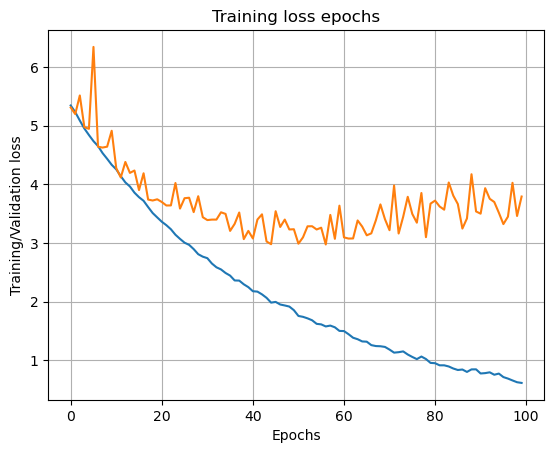

In [16]:
# I looked up how to bold words so I could make test accuracy more visible in output
bold_start = "\033[1m"
bold_end = "\033[0m"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose(
    [transforms.Resize((448, 448)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])


batch_size = 128
epochs = 100
num_classes = 200

def create_list_of_epochs(epochs):
    list_of_epochs = []
    for epoch in range(epochs):
        list_of_epochs.append(epoch)
    return list_of_epochs


train_dataset = datasets.ImageFolder("CUB_200_2011_reorganized/train",
                                     transform=train_transform)
length_of_inital_train_dataset = int(0.95 * len(train_dataset))
length_of_validation_dataset = len(train_dataset) - length_of_inital_train_dataset
train_dataset, validation_dataset = random_split(
    train_dataset, [length_of_inital_train_dataset, length_of_validation_dataset])
validation_dataset.transform = transform
test_dataset = datasets.ImageFolder("CUB_200_2011_reorganized/test",
                                    transform=transform)

print(f"size of validation dataset {len(validation_dataset)}")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

#model = models.resnet34(weights=None)
model = MyNet()
model = nn.DataParallel(model)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
validation_loss_tracker = []

list_of_training_loss = []

#model.summary()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    training_loss_for_epoch = running_loss/len(train_dataset)
    list_of_training_loss.append(training_loss_for_epoch)

    model.eval()
    validation_loss = 0
    correct_for_validation = 0
    total_for_validation = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            nothing, predicted = torch.max(outputs.data, 1)
            total_for_validation += labels.size(0)
            correct_for_validation += (predicted == labels).sum().item()
    avg_val_loss = validation_loss / len(validation_dataset)
    validation_loss_tracker.append(avg_val_loss)
    accuracy = 100 * correct_for_validation / total_for_validation
    print(f"Epoch {epoch} Training Loss {training_loss_for_epoch}. Validation Loss {avg_val_loss} Accuracy {accuracy}")
    #scheduler.step(avg_val_loss)


correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        model.eval()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        nothing, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'{bold_start}Test Accuracy: {100 * correct // total} % {bold_end}')


list_of_epochs = create_list_of_epochs(epochs)

plt.xlabel("Epochs")
plt.ylabel("Training/Validation loss")
plt.title("Training loss epochs")
plt.plot(list_of_epochs, list_of_training_loss, label="Training Loss")
plt.plot(list_of_epochs, validation_loss_tracker, label="Validation loss")
plt.grid(True)
plt.show()
